# Forecasting of Apple stock from 1st December to 15th December 2020

### Forecasting methods used
1. ARIMA
2. SARIMA
3. Vector autoregression

## References

1. https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
2. https://techrando.com/2019/07/19/analyzing-electricity-price-time-series-data-using-python-time-series-decomposition-and-price-forecasting-using-a-vector-autoregression-var-model/
3. https://github.com/ritvikmath/Time-Series-Analysis

## Libraries

In [1]:
import yfinance as yf

import pandas as pd

from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans

from scipy.stats import pearsonr

import numpy as np



## Get Data

In [2]:
#define the ticker symbol
tickerSymbol = 'aapl'

In [3]:
#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

print(tickerData)
#get the historical prices for this ticker
#tickerDf = yf.download(tickerSymbol,threads= False,start='2017-1-1',end='2020-12-30')
tickerDf = tickerData.history(interval='1d', start='2017-1-1', end='2020-12-30',threads= False)

yfinance.Ticker object <AAPL>


In [4]:
priceData = tickerDf.Open

priceData = priceData.asfreq(pd.infer_freq(priceData.index))

print(priceData)

Date
2017-01-03     27.330766
2017-01-04     27.342568
2017-01-05     27.359092
2017-01-06     27.562064
2017-01-07           NaN
                 ...    
2020-12-25           NaN
2020-12-26           NaN
2020-12-27           NaN
2020-12-28    133.563211
2020-12-29    137.610278
Freq: D, Name: Open, Length: 1457, dtype: float64


Text(0.5, 1.0, 'aapl Price Data')

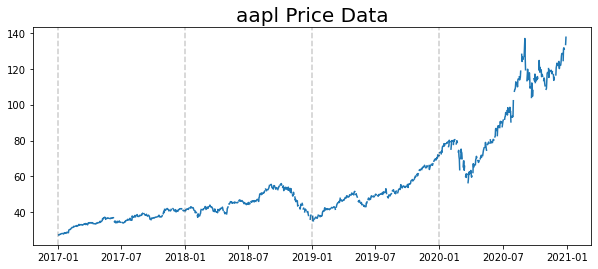

In [5]:
plt.figure(figsize=(10,4))
plt.plot(priceData)
for year in range(priceData.index[0].year, priceData.index[-1].year+1):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.2)
plt.title("%s Price Data"%tickerSymbol, fontsize=20)

## Data cleaning and exploratory analysis
- Data is not stationary
- Missing data can be filled with previous available values

In [6]:
priceData.ffill(inplace=True)

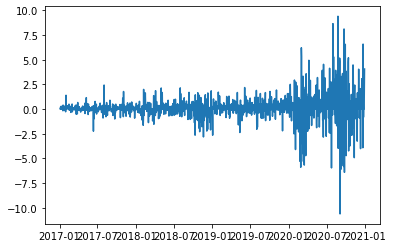

In [7]:
# Differencing to make values stationary

priceDiffData = priceData.diff(1)[1:]
plt.plot(priceDiffData)

In [8]:
print(priceData)

Date
2017-01-03     27.330766
2017-01-04     27.342568
2017-01-05     27.359092
2017-01-06     27.562064
2017-01-07     27.562064
                 ...    
2020-12-25    130.901713
2020-12-26    130.901713
2020-12-27    130.901713
2020-12-28    133.563211
2020-12-29    137.610278
Freq: D, Name: Open, Length: 1457, dtype: float64


<AxesSubplot:xlabel='Date'>

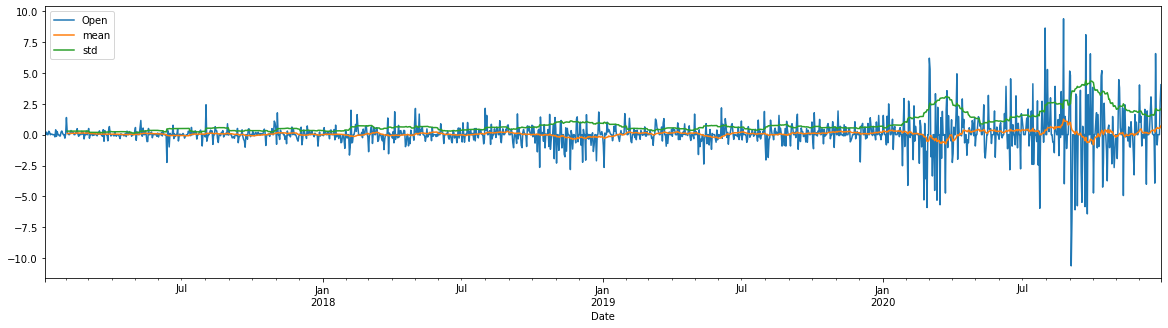

In [9]:
data_st = pd.concat([priceDiffData, priceDiffData.rolling(30).agg(['mean', np.std])], axis=1)

data_st.plot(figsize=(20,5))

- Almost constant mean and standard deviation with slight changes from 2020 owing to the pandemic
- Let's use Dicky fuller test to determine if time series is stationary

In [10]:
result = adfuller(data_st['Open'])

print('p-value: %f' % result[1])

if result[1] <= 0.05:
    print("Data is stationary")
else:
    print("Data is not stationary")

p-value: 0.000000
Data is stationary


In [11]:
std_year = data_st.groupby(data_st.index.year).std()
print(std_year)

          Open      mean       std
Date                              
2017  0.350991  0.065623  0.116545
2018  0.673883  0.127862  0.223055
2019  0.592840  0.118056  0.133085
2020  2.263783  0.338617  0.917962


- High volatility of in the year 2020 owing to the uncertainity of business situation due to the pandemic

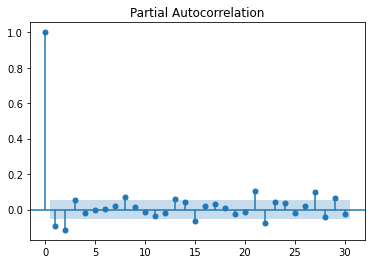

In [12]:
plot_pacf(data_st['Open'],lags=30)
plt.show()

- Direct Correlation till 8th week

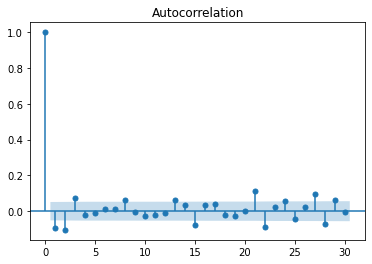

In [13]:
plot_acf(data_st['Open'],lags=30)
plt.show()

- Indirect and direct correlation till 8th week

### ARIMA model forecasting

In [14]:
train_end = datetime(2020,12,1)
test_end = datetime(2020,12,15)

train = priceData[:train_end]
test  = priceData[train_end:test_end]

model = ARIMA(train, order=(15,1,15))

In [15]:
model_fit = model.fit()

In [16]:
#summary of the model
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.Open   No. Observations:                 1428
Model:               ARIMA(15, 1, 15)   Log Likelihood               -2234.811
Method:                       css-mle   S.D. of innovations              1.150
Date:                Wed, 28 Jul 2021   AIC                           4533.622
Time:                        15:37:14   BIC                           4702.071
Sample:                    01-04-2017   HQIC                          4596.530
                         - 12-01-2020                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0639      0.028      2.260      0.024       0.008       0.119
ar.L1.D.Open      0.0797        nan        nan        nan         nan         nan
ar.L2.D.Open      0.3936        nan     

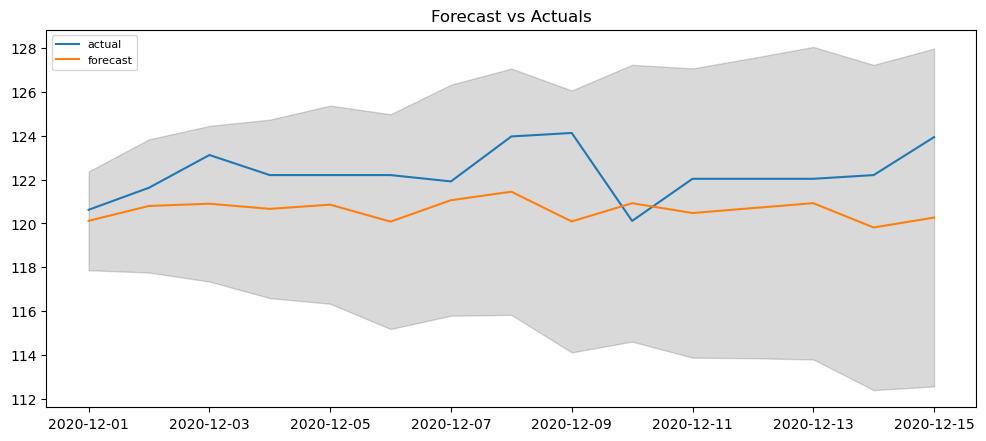

In [17]:
fc, se, conf = model_fit.forecast(len(test),alpha=0.05)

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
#plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [18]:
def mean_absolute_percentage_error(y_true, y_pred): 
 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [19]:
print("The MAPE error is: ",mean_absolute_percentage_error(test,fc_series))

The MAPE error is:  1.4598905423293302


## SARIMA model forecasting

In [20]:
priceDiff = priceData.diff(365)[1:]

print(priceDiff)

Date
2017-01-04          NaN
2017-01-05          NaN
2017-01-06          NaN
2017-01-07          NaN
2017-01-08          NaN
                ...    
2020-12-25    60.531232
2020-12-26    58.974703
2020-12-27    58.974703
2020-12-28    61.636201
2020-12-29    66.093408
Freq: D, Name: Open, Length: 1456, dtype: float64


<AxesSubplot:xlabel='Date'>

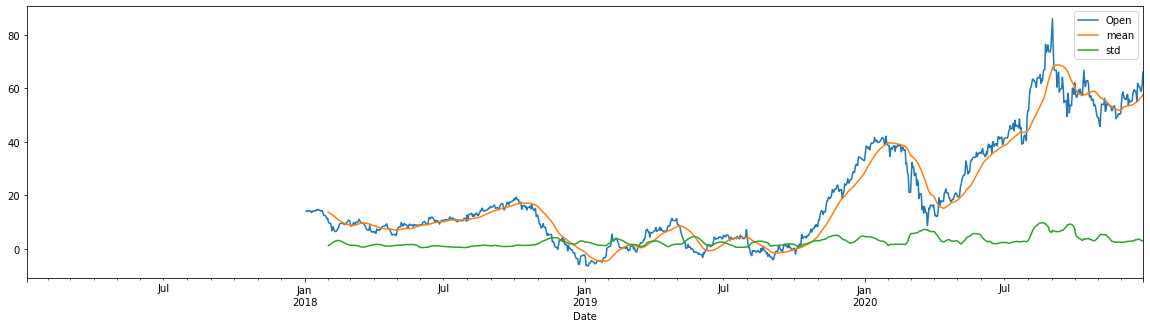

In [21]:
data_st = pd.concat([priceDiff, priceDiff.rolling(30).agg(['mean', np.std])], axis=1)

data_st.plot(figsize=(20,5))

- Constant standard deviation but not mean

<AxesSubplot:xlabel='Date'>

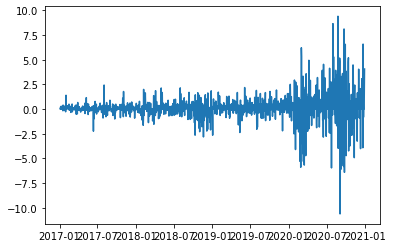

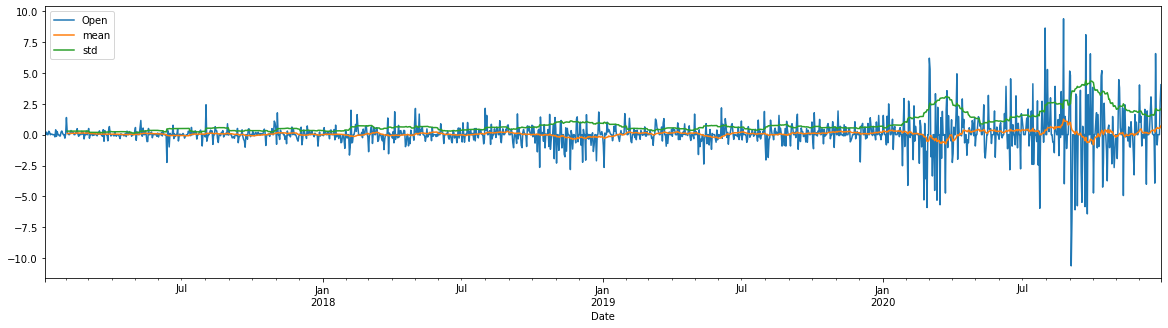

In [22]:
# Differencing by 1 to make values stationary
priceDiffData = priceData.diff(1)[1:]
plt.plot(priceDiffData)

data_st = pd.concat([priceDiffData, priceDiffData.rolling(30).agg(['mean', np.std])], axis=1)
data_st.plot(figsize=(20,5))

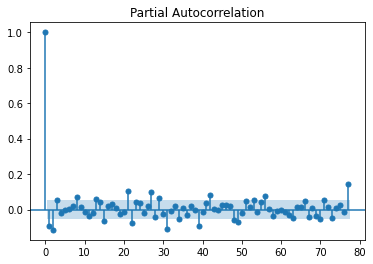

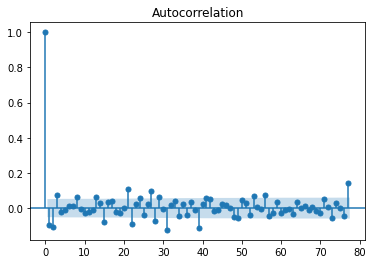

In [23]:
plot_pacf(data_st['Open'],lags=77)
plt.show()

plot_acf(data_st['Open'],lags=77)
plt.show()

In [24]:
my_order = (2,1,3)
my_seasonal_order = (1, 0, 1, 77)
# define model

train_end = datetime(2020,12,1)
test_end = datetime(2020,12,15)

train = priceData[:train_end]
test  = priceData[train_end:test_end]

model = SARIMAX(train, order=my_order, seasonal_order=my_seasonal_order)

In [25]:
model_fit = model.fit()


In [26]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                 Open   No. Observations:                 1429
Model:             SARIMAX(2, 1, 3)x(1, 0, [1], 77)   Log Likelihood               -2266.901
Date:                              Wed, 28 Jul 2021   AIC                           4549.802
Time:                                      15:38:43   BIC                           4591.914
Sample:                                  01-03-2017   HQIC                          4565.529
                                       - 12-01-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3220      0.290     -1.110      0.267      -0.891       0.247
ar.L2         -0.14

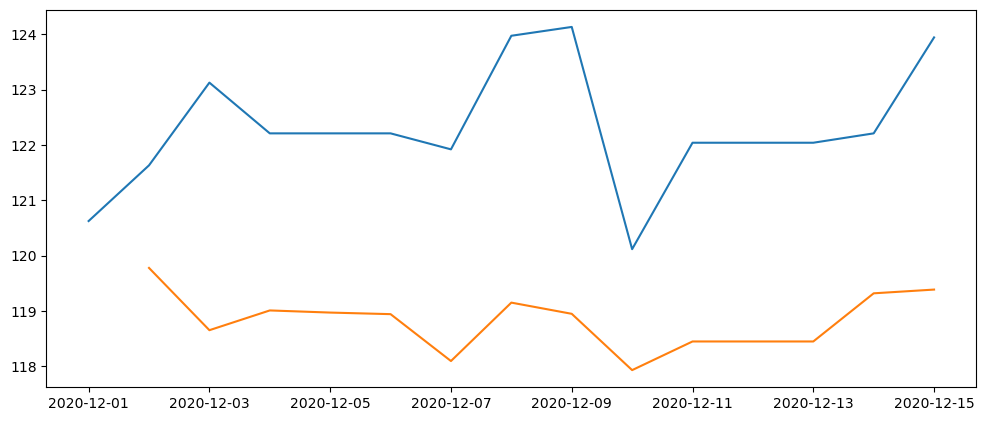

In [27]:
test = test.to_frame()

test['Pred'] = model_fit.forecast(len(test))

## Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test["Open"], label='actual')
plt.plot(test['Pred'], label='forecast')
plt.show()

In [28]:
print("The MAPE error is: ",mean_absolute_percentage_error(test["Open"],test["Pred"]))

The MAPE error is:  2.9289958411623718


- Let's see if stock performance of Microsoft can be used to forecast stock performance of Apple

# Vector auto regression

- Regression with the help of Apple's competitor Microsoft

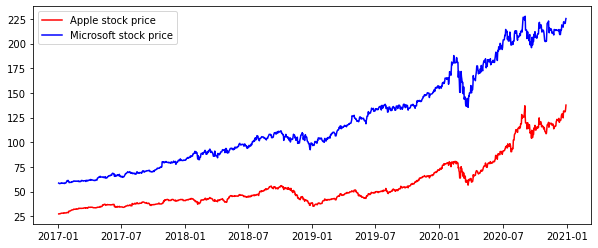

In [29]:
# Get data for Microsft
tickerSymbol = 'MSFT'
tickerData = yf.Ticker(tickerSymbol)
tickerDf = tickerData.history(interval='1d', start='2017-1-1', end='2020-12-30')
NewpriceData = tickerDf.Open
NewpriceData = NewpriceData.asfreq(pd.infer_freq(priceData.index))
NewpriceData.ffill(inplace=True)

plt.figure(figsize=(10,4))
plt.plot(priceData,'-r',label='Apple stock price')
plt.plot(NewpriceData,'-b',label='Microsoft stock price')
plt.legend()
plt.show()

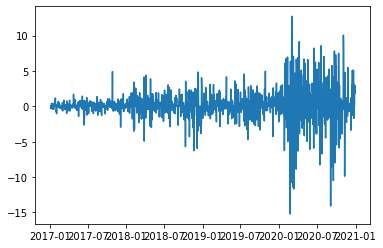

In [30]:
# Differencing to make values stationary

NewpriceDiffData = NewpriceData.diff(1)[1:]
plt.plot(NewpriceDiffData)

In [31]:
result = adfuller(NewpriceDiffData)

print('p-value: %f' % result[1])

if result[1] <= 0.05:
    print("Data is stationary")
else:
    print("Data is not stationary")

p-value: 0.000000
Data is stationary


### Getting lag through Pearson correlation

In [32]:
for lag in range(1, 40):
    Apple_series = priceDiffData[lag:]
    Dell_series = NewpriceDiffData[:-lag]
    print('Lag: ',lag)
    print(pearsonr(Apple_series, Dell_series))
    
    print("*********")
    

Lag:  1
(-0.12891893620224681, 8.059582055544111e-07)
*********
Lag:  2
(-0.03375050482795929, 0.19836909374018785)
*********
Lag:  3
(0.06776234708234692, 0.009773874971646244)
*********
Lag:  4
(0.011116266398013167, 0.6721238758496719)
*********
Lag:  5
(-0.026041355116107914, 0.3215487055138513)
*********
Lag:  6
(-0.003896425452747194, 0.8821501560552009)
*********
Lag:  7
(0.033675381625517004, 0.2001461970852129)
*********
Lag:  8
(-0.03431042548347532, 0.1919414139960469)
*********
Lag:  9
(-0.03605673026998791, 0.17042523348128263)
*********
Lag:  10
(0.02306124771923137, 0.3808711824364101)
*********
Lag:  11
(-0.018175781970218394, 0.4899565477558942)
*********
Lag:  12
(0.05859593561989407, 0.025971972743045954)
*********
Lag:  13
(0.01457043246922655, 0.5802398602655559)
*********
Lag:  14
(-0.013051192106039857, 0.6204638678376911)
*********
Lag:  15
(-0.04415891447898949, 0.09380531065109289)
*********
Lag:  16
(0.005743522971495683, 0.8276130738493852)
*********
Lag:  1

- Highest negative correlation with lag 22
- Hence, maxlags defined as 22

In [33]:
df = pd.DataFrame()
df["Apple Stock"] = priceDiffData
df["Microsoft Stock"] = NewpriceDiffData

train_end = datetime(2020,12,1)
test_end = datetime(2020,12,15)

train = df[:train_end]
test = df[train_end:test_end]


In [34]:
model = VAR(train)

model_fit = model.fit(maxlags=22)
model_fit.summary()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 28, Jul, 2021
Time:                     15:38:44
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    1.33510
Nobs:                     1406.00    HQIC:                   1.12470
Log likelihood:          -4602.45    FPE:                    2.71606
AIC:                     0.999138    Det(Omega_mle):         2.55020
--------------------------------------------------------------------
Results for equation Apple Stock
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                       0.080505         0.032711            2.461           0.014
L1.Apple Stock             -0.026082         0.039097           -0.667           0.505
L1.Microsoft Stock         -0.

In [35]:
# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(test))
print(prediction)

[[-0.17310379  1.08129548]
 [-0.9180892  -0.5358057 ]
 [ 0.45725142  0.01729604]
 [ 0.44122955  0.2852461 ]
 [ 0.44078891  0.55697571]
 [ 0.03211461  0.37604487]
 [ 0.08637643  0.29271614]
 [ 0.98273311  0.95683826]
 [ 0.05001822 -0.02773183]
 [-0.49587858 -0.16156693]
 [-0.51017219 -0.83459269]
 [-0.23977883 -0.1248435 ]
 [ 0.50032924  0.52778446]
 [-0.09713278  0.13069114]
 [-0.27949068 -0.33454115]]


In [36]:
#converting predictions to dataframe
cols = df.columns

pred = pd.DataFrame(index=test.index,columns=cols)



for j in range(0,2):
    for i in range(0, len(prediction)):
        
        pred.iloc[i][j] = prediction[i][j]
        
print(mean_absolute_percentage_error(pred["Microsoft Stock"], test["Microsoft Stock"]))
print(mean_absolute_percentage_error(pred["Apple Stock"], test["Apple Stock"]))

807.7033294566592
434.3769253644833


In [37]:
append_df_org = pd.concat([train,test])
append_df_comp = pd.concat([train,pred])

### Reverse the pre-processing steps

In [38]:
for i in range(1,len(append_df_org)):
    append_df_org.iloc[i]['Apple Stock']= append_df_org.iloc[i-1]['Apple Stock']+ \
    append_df_org.iloc[i]['Apple Stock']
    
    append_df_org.iloc[i]["Microsoft Stock"]= append_df_org.iloc[i-1]["Microsoft Stock"]+ \
    append_df_org.iloc[i]["Microsoft Stock"]

In [39]:
for i in range(1,len(append_df_comp)):
    append_df_comp.iloc[i]['Apple Stock']= append_df_comp.iloc[i-1]['Apple Stock']+ \
    append_df_comp.iloc[i]['Apple Stock']
    
    append_df_comp.iloc[i]["Microsoft Stock"]= append_df_comp.iloc[i-1]["Microsoft Stock"]+ \
    append_df_comp.iloc[i]["Microsoft Stock"]
    
    


### Get prediction error

In [40]:
print("MAPE between predicted and actual Microsoft stocks: ",mean_absolute_percentage_error(append_df_org.loc[train_end:test_end]["Microsoft Stock"], append_df_comp[train_end:test_end]["Microsoft Stock"]))
print("MAPE between predicted and actual Apple stocks: ",mean_absolute_percentage_error(append_df_org.loc[train_end:test_end]["Apple Stock"], append_df_comp.loc[train_end:test_end]["Apple Stock"]))

MAPE between predicted and actual Microsoft stocks:  1.627515356797817
MAPE between predicted and actual Apple stocks:  5.103816311139582


- Not an improvement over the ARIMA model

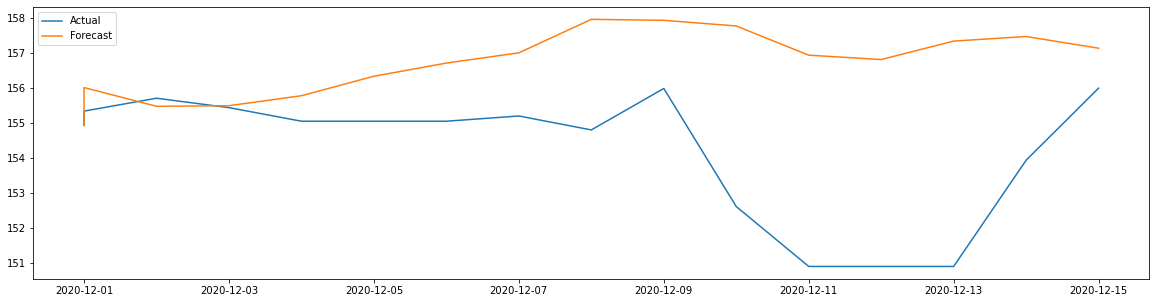

In [41]:
plt.figure(figsize=(20,5))

plt.plot(append_df_org.loc[train_end:test_end]["Microsoft Stock"], label='Actual')
plt.plot(append_df_comp[train_end:test_end]["Microsoft Stock"], label='Forecast')
plt.legend()
plt.show()

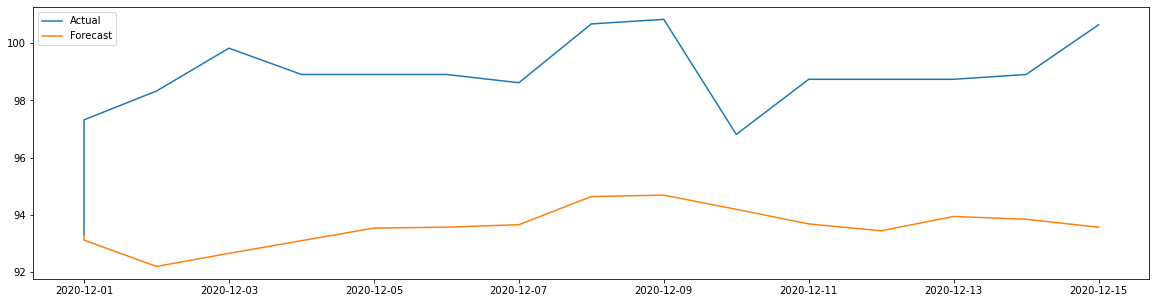

In [42]:
plt.figure(figsize=(20,5))

plt.plot(append_df_org.loc[train_end:test_end]["Apple Stock"], label='Actual')
plt.plot(append_df_comp.loc[train_end:test_end]["Apple Stock"], label='Forecast')
plt.legend()
plt.show()

# Anomaly detection 

In [43]:
#define the ticker symbol
tickerSymbol = 'aapl'

In [44]:
#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)
#get the historical prices for this ticker
tickerDf = tickerData.history(interval='1d', start='2017-1-1', end='2020-12-30')

In [45]:
priceData = tickerDf.Open
priceData = priceData.asfreq(pd.infer_freq(priceData.index))
priceData.ffill(inplace=True)


# Differencing to make values stationary
priceDiffData = priceData.diff(1)[1:]

<AxesSubplot:xlabel='Date'>

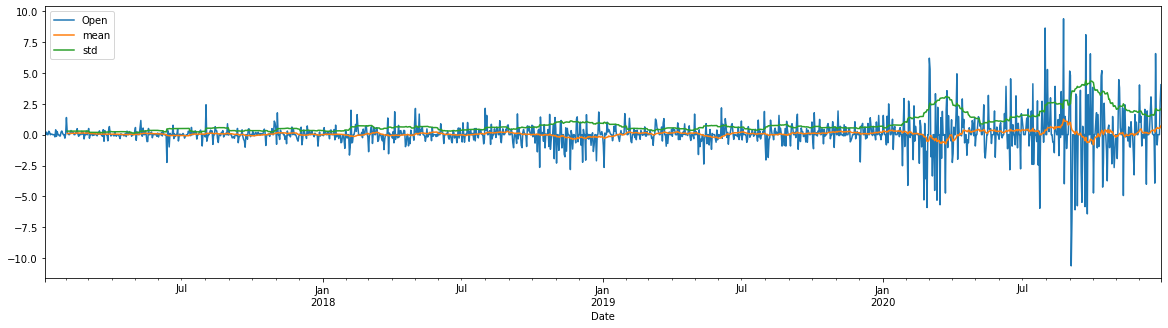

In [46]:
data_st = pd.concat([priceDiffData, priceDiffData.rolling(30).agg(['mean', np.std])], axis=1)
data_st.plot(figsize=(20,5))

## Anomaly detection through rolling mean
- Define threshold
- Give alerts once rolling standard deviation breaches a threshold (1)

In [47]:
print(data_st)

                Open      mean       std
Date                                    
2017-01-04  0.011802       NaN       NaN
2017-01-05  0.016524       NaN       NaN
2017-01-06  0.202972       NaN       NaN
2017-01-07  0.000000       NaN       NaN
2017-01-08  0.000000       NaN       NaN
...              ...       ...       ...
2020-12-25  0.000000  0.523992  1.961864
2020-12-26  0.000000  0.523992  1.961864
2020-12-27  0.000000  0.490101  1.961840
2020-12-28  2.661498  0.578817  1.998744
2020-12-29  4.047067  0.713719  2.092698

[1456 rows x 3 columns]


In [48]:
data_st.reset_index(inplace=True)

In [49]:
Dates = []

for i in range(0,len(data_st)):
    
    if data_st.iloc[i]["std"] > 1:
        
        Dates.append(data_st.iloc[i]["Date"])

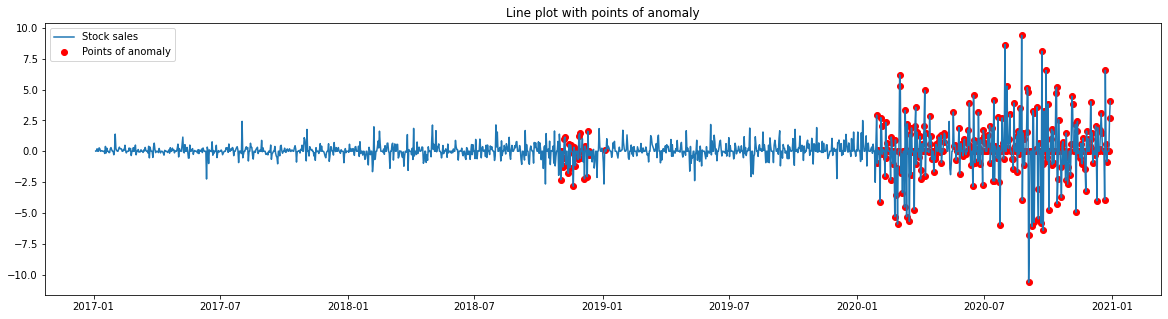

In [50]:
plt.figure(figsize=(20,5))
plt.plot(data_st["Date"],data_st["Open"],label="Stock sales")
plt.scatter(x="Date",y="Open",data = data_st.loc[data_st.Date.isin(Dates),:],color="red",label="Points of anomaly")
plt.title("Line plot with points of anomaly")
plt.legend()
plt.show()

- Corresponds to the time of pandemic and volataile stock market situtation on December 2018
- https://en.wikipedia.org/wiki/COVID-19_recession
- https://www.pbs.org/newshour/economy/making-sense/6-factors-that-fueled-the-stock-market-dive-in-2018

## Anomaly detection through K - Means clustering

1. Automated in nature
2. Rolling standard deviation will be used as it is independant of direction

In [51]:
data_st.fillna(0,inplace=True)

[1 1 1 ... 0 0 0]


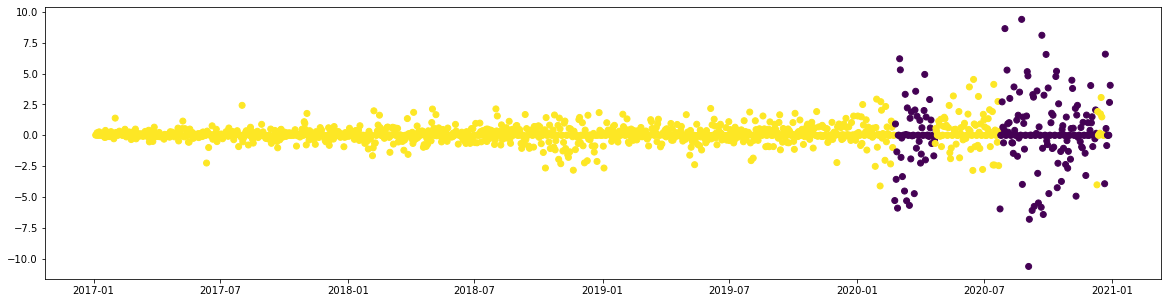

In [52]:
kmeans = KMeans(n_clusters=2).fit(data_st["std"].values.reshape(-1,1))
labels = kmeans.predict(data_st["std"].values.reshape(-1,1))

print(labels)

plt.figure(figsize=(20,5))
plt.scatter(data_st["Date"],data_st["Open"],c=labels)
plt.show()

- Purple labels are indicative of the anomaly
- Indicative of the pandemic induced uncertainity